In [1]:
import torch.nn.functional as F
import voc12.dataloader
import numpy as np
import argparse
import torch
import os
from PIL import Image
from torch.utils.data import DataLoader
from misc import pyutils, torchutils
from net.resnet50_cam import CAM
from misc import imutils
import matplotlib.pyplot as plt
from torch import nn
from net import resnet50

In [84]:
class MyCAM(nn.Module):
    def __init__(self):
        super(MyCAM, self).__init__()
        self.resnet50 = resnet50.resnet50(
            pretrained=True, strides=(2, 2, 2, 1))

        self.stage1 = nn.Sequential(self.resnet50.conv1, self.resnet50.bn1, self.resnet50.relu, self.resnet50.maxpool,
                                    self.resnet50.layer1)
        self.stage2 = nn.Sequential(self.resnet50.layer2)
        self.stage3 = nn.Sequential(self.resnet50.layer3)
        self.stage4 = nn.Sequential(self.resnet50.layer4)

        self.classifier = nn.Conv2d(2048, 20, 1, bias=False)

        self.backbone = nn.ModuleList(
            [self.stage1, self.stage2, self.stage3, self.stage4])
        self.newly_added = nn.ModuleList([self.classifier])
        self.gamma = torch.nn.Parameter(torch.ones(1, 20) * 0.1)

    def forward(self, x):
        print(x.shape)
        x = self.stage1(x)
        print(torch.mean(torch.abs(x)))
        print(x.shape)
        x = self.stage2(x)
        print(torch.mean(torch.abs(x)))
        print(x.shape)
        x = self.stage3(x)
        print(torch.mean(torch.abs(x)))
        print(x.shape)
        x = self.stage4(x)
        print(torch.mean(torch.abs(x)))
        x = F.conv2d(x, self.classifier.weight)
        x = F.relu(x)
        print(torch.mean(torch.abs(x)))
        x = x[0] + x[1].flip(-1)
        return x

    def train(self, mode=True):
        for p in self.resnet50.conv1.parameters():
            p.requires_grad = False
        for p in self.resnet50.bn1.parameters():
            p.requires_grad = False

    def trainable_parameters(self):
        return (list(self.backbone.parameters()), list(self.newly_added.parameters()))

In [94]:
cam_eval_thres = 0.16
chainer_eval_set = 'train'
voc12_root = '/Users/Andy/Projects/dataset/VOCdevkit/VOC2012'
cam_out_dir = '/Users/Andy/Projects/dataset/VOCdevkit/VOC2012/C2AM'
cam_out_dir_baseline = '/Users/Andy/Projects/dataset/VOCdevkit/VOC2012/CAM'
train_list = '/Users/Andy/Projects/c2am/voc12/train_aug.txt'
voc12_root = '/Users/Andy/Projects/dataset/VOCdevkit/VOC2012'

baseline_cam_weight_path = '/Users/Andy/Projects/resnet50_baseline_512.pth'
trained_cam_weight_path = '/Users/Andy/Projects/resnet50_c2am_exp_07.pth'

model_baseline = MyCAM()
model_trained = MyCAM()
model_baseline.eval()
model_trained.eval()
model_baseline.load_state_dict(torch.load(baseline_cam_weight_path, map_location='cpu'), strict=False)
model_trained.load_state_dict(torch.load(trained_cam_weight_path, map_location='cpu'))
print(model_baseline)

MyCAM(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): FixedBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): FixedBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FixedBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): FixedBatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [125]:
x1 = torch.ones((2, 1024, 21, 32))
x2 = torch.ones((2, 1024, 21, 32))

o = x1
for i, p in enumerate(model_baseline.stage4[0]):
    o = p(o)
    print(i, torch.mean(torch.abs(o)))
    
    
o = x2
for i, p in enumerate(model_trained.stage4[0]):
    o = p(o)
    print(i, torch.mean(torch.abs(o)))
    
    
x2 = torch.ones((2, 2048, 21, 32))
print(torch.mean(torch.abs(model_baseline.stage4[0][2](x2))))
print(torch.mean(torch.abs(model_trained.stage4[0][2](x2))))

0 tensor(0.4024, grad_fn=<MeanBackward0>)
1 tensor(1.1085, grad_fn=<MeanBackward0>)
2 tensor(3.2631, grad_fn=<MeanBackward0>)
0 tensor(0.4641, grad_fn=<MeanBackward0>)
1 tensor(1.5309, grad_fn=<MeanBackward0>)
2 tensor(12.1804, grad_fn=<MeanBackward0>)
tensor(0.7260, grad_fn=<MeanBackward0>)
tensor(0.8665, grad_fn=<MeanBackward0>)


In [106]:
print(model_baseline.stage4[0][2])

Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): FixedBatchNorm(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): FixedBatchNorm(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): FixedBatchNorm(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)


In [116]:
for i, p in enumerate(model_baseline.stage4[0][2].parameters()):
    print(i, torch.mean(p))
    
for i, p in enumerate(model_trained.stage4[0][2].parameters()):
    print(i, torch.mean(p))

0 tensor(-0.0004, grad_fn=<MeanBackward0>)
1 tensor(0.2167, grad_fn=<MeanBackward0>)
2 tensor(-0.1687, grad_fn=<MeanBackward0>)
3 tensor(-0.0006, grad_fn=<MeanBackward0>)
4 tensor(0.2123, grad_fn=<MeanBackward0>)
5 tensor(-0.0857, grad_fn=<MeanBackward0>)
6 tensor(-0.0002, grad_fn=<MeanBackward0>)
7 tensor(0.7038, grad_fn=<MeanBackward0>)
8 tensor(0.0241, grad_fn=<MeanBackward0>)
0 tensor(-0.0004, grad_fn=<MeanBackward0>)
1 tensor(0.2169, grad_fn=<MeanBackward0>)
2 tensor(-0.1687, grad_fn=<MeanBackward0>)
3 tensor(-0.0006, grad_fn=<MeanBackward0>)
4 tensor(0.2125, grad_fn=<MeanBackward0>)
5 tensor(-0.0857, grad_fn=<MeanBackward0>)
6 tensor(-0.0002, grad_fn=<MeanBackward0>)
7 tensor(0.7038, grad_fn=<MeanBackward0>)
8 tensor(0.0241, grad_fn=<MeanBackward0>)


In [34]:
train_list = '/Users/Andy/Projects/c2am/voc12/train.txt'
voc12_root = '/Users/Andy/Projects/dataset/VOCdevkit/VOC2012'

train_dataset = voc12.dataloader.VOC12ClassificationDatasetMSF(train_list,
                                                          voc12_root=voc12_root,
                                                          scales=(1.0, 0.5, 1.5, 2.0))
train_loader = DataLoader(train_dataset, shuffle=False)

val_list = '/Users/Andy/Projects/c2am/voc12/val.txt'

val_dataset = voc12.dataloader.VOC12ClassificationDatasetMSF(val_list,
                                                          voc12_root=voc12_root,
                                                          scales=(1.0, 0.5, 1.5, 2.0))
val_loader = DataLoader(val_dataset, shuffle=False)

In [14]:
for pack in train_loader:
    name = pack['name'][0]
    # print(name)
    if name == '2007_000876':
        print(pack['label'][0])
        break

tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])


In [53]:
with torch.no_grad():
    img_name = pack['name'][0]
    imgs = pack['img']
    label = pack['label'][0]
    size = pack['size']
    
    c1 = model_baseline(pack['img'][0][0])
    c2 = model_trained(pack['img'][0][0])

torch.Size([2, 3, 334, 500])
tensor(0.1684)
torch.Size([2, 256, 84, 125])
tensor(0.1033)
torch.Size([2, 512, 42, 63])
tensor(0.0506)
torch.Size([2, 1024, 21, 32])
tensor(0.6811)
tensor(1.9830)
torch.Size([2, 3, 334, 500])
tensor(0.1699)
torch.Size([2, 256, 84, 125])
tensor(0.1077)
torch.Size([2, 512, 42, 63])
tensor(0.0598)
torch.Size([2, 1024, 21, 32])
tensor(3.3894)
tensor(8.3206)


In [19]:
print(model_baseline.classifier.weight[7][0])
print(model_trained.classifier.weight[7][0])

print(cf1[0][0])
print(cf2[0][0])

print(cf1.shape)

tensor([[0.0057]], grad_fn=<SelectBackward0>)
tensor([[0.0054]], grad_fn=<SelectBackward0>)
tensor([[0.3504]])
tensor([[0.3503]])
torch.Size([2, 2048, 1, 1])


In [50]:
for i in range(2048):
    plt.imshow(f1[0][i].squeeze())
    plt.title('{}'.format(model_baseline.classifier.weight[7][i].squeeze()))
    plt.colorbar()
    plt.savefig('../feature_maps/baseline/feat_{}.png'.format(i))
    plt.clf()
    plt.imshow(f2[0][i].squeeze())
    plt.title('{}'.format(model_trained.classifier.weight[7][i].squeeze()))
    plt.colorbar()
    plt.savefig('../feature_maps/scaled/feat_{}.png'.format(i))
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [188]:
print(model_baseline.classifier.weight)
print(model_trained.classifier.weight)

Parameter containing:
tensor([[[[-0.0038]],

         [[-0.0213]],

         [[-0.0232]],

         ...,

         [[-0.0221]],

         [[-0.0168]],

         [[ 0.0175]]],


        [[[-0.0328]],

         [[ 0.0514]],

         [[-0.0126]],

         ...,

         [[ 0.0063]],

         [[-0.0349]],

         [[-0.0382]]],


        [[[-0.0050]],

         [[-0.0474]],

         [[-0.0006]],

         ...,

         [[ 0.0149]],

         [[ 0.0011]],

         [[-0.0102]]],


        ...,


        [[[-0.0003]],

         [[-0.0238]],

         [[-0.0296]],

         ...,

         [[-0.0165]],

         [[-0.0041]],

         [[-0.0097]]],


        [[[-0.0339]],

         [[-0.0329]],

         [[-0.0199]],

         ...,

         [[ 0.0027]],

         [[-0.0280]],

         [[-0.0017]]],


        [[[-0.0039]],

         [[-0.0375]],

         [[-0.0159]],

         ...,

         [[ 0.0005]],

         [[-0.0024]],

         [[ 0.0151]]]], requires_grad=True)
Parameter cont

In [29]:
with torch.no_grad():
    img_name = pack['name'][0]
    imgs = pack['img']
    label = pack['label'][0]
    size = pack['size']
    
    strided_up_size = imutils.get_strided_up_size(size, 16)
    
    baseline_outputs = [model_baseline(img[0])[0] for img in pack['img']]
    trained_outputs = [model_trained(img[0])[0] for img in pack['img']]
    
    baseline_highres_cam = [F.interpolate(torch.unsqueeze(
                o, 1), strided_up_size, mode='bilinear', align_corners=False) for o in baseline_outputs]
    baseline_highres_cam = torch.sum(torch.stack(baseline_highres_cam, 0), 0)[
                :, 0, :size[0], :size[1]]
    
    trained_highres_cam = [F.interpolate(torch.unsqueeze(
                o, 1), strided_up_size, mode='bilinear', align_corners=False) for o in trained_outputs]
    trained_highres_cam = torch.sum(torch.stack(trained_highres_cam, 0), 0)[
                :, 0, :size[0], :size[1]]

    valid_cat = torch.nonzero(label)[:, 0]

    baseline_highres_cam = baseline_highres_cam[valid_cat]
    trained_highres_cam = trained_highres_cam[valid_cat]
    baseline_highres_cam /= F.adaptive_max_pool2d(baseline_highres_cam, (1, 1)) + 1e-5
    trained_highres_cam /= F.adaptive_max_pool2d(trained_highres_cam, (1, 1)) + 1e-5

In [59]:
def plot(img_name):
    cam_dict = np.load(os.path.join(cam_out_dir, img_name + '.npy'), allow_pickle=True).item()
    cam_dict_baseline = np.load(os.path.join(cam_out_dir_baseline, img_name + '.npy'), allow_pickle=True).item()
    im = Image.open(os.path.join(voc12_root, 'JPEGImages', img_name + '.jpg'))
    pseudo = Image.open(os.path.join(voc12_root, 'SegmentationClassAug', img_name + '.png'))
    pseudo_color = imutils.colorize_label(np.asarray(pseudo), by_hue=False, normalize=False)
    pseudo_color = Image.fromarray(pseudo_color.astype(np.uint8))
    gt = Image.open(os.path.join(voc12_root, 'SegmentationClass', img_name + '.png'))

    pseudo_cam = Image.open(os.path.join(voc12_root, 'SegmentationCAM', img_name + '.png'))
    pseudo_cam_color = imutils.colorize_label(np.asarray(pseudo_cam), by_hue=False, normalize=False)
    pseudo_cam_color = Image.fromarray(pseudo_cam_color.astype(np.uint8))

    # Row 1
    fig = plt.figure(figsize=(32,18))
    fig.tight_layout()
    ax = fig.add_subplot(341)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    plt.title('Image', fontdict={'fontsize': 30})
    ax.imshow(im)
    ax = fig.add_subplot(342)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    plt.title('CAM', fontdict={'fontsize': 30})
    ax.imshow(cam_dict_baseline['high_res'][0].squeeze())
    ax = fig.add_subplot(343)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    plt.title('Pseudo Mask', fontdict={'fontsize': 30})
    ax.imshow(pseudo_cam_color)
    ax = fig.add_subplot(344)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    plt.title('Segmentation', fontdict={'fontsize': 30})
    ax.imshow(im)
    # Row 2
    ax = fig.add_subplot(345)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    plt.title('Ground Truth', fontdict={'fontsize': 30})
    ax.imshow(gt)
    ax = fig.add_subplot(346)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    plt.title('C$^2$AM', fontdict={'fontsize': 30})
    ax.imshow(cam_dict['high_res'][0].squeeze())
    ax = fig.add_subplot(347)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    plt.title('Pseudo Mask', fontdict={'fontsize': 30})
    ax.imshow(pseudo_color)
    ax = fig.add_subplot(348)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    plt.title('Segmentation', fontdict={'fontsize': 30})
    ax.imshow(im)

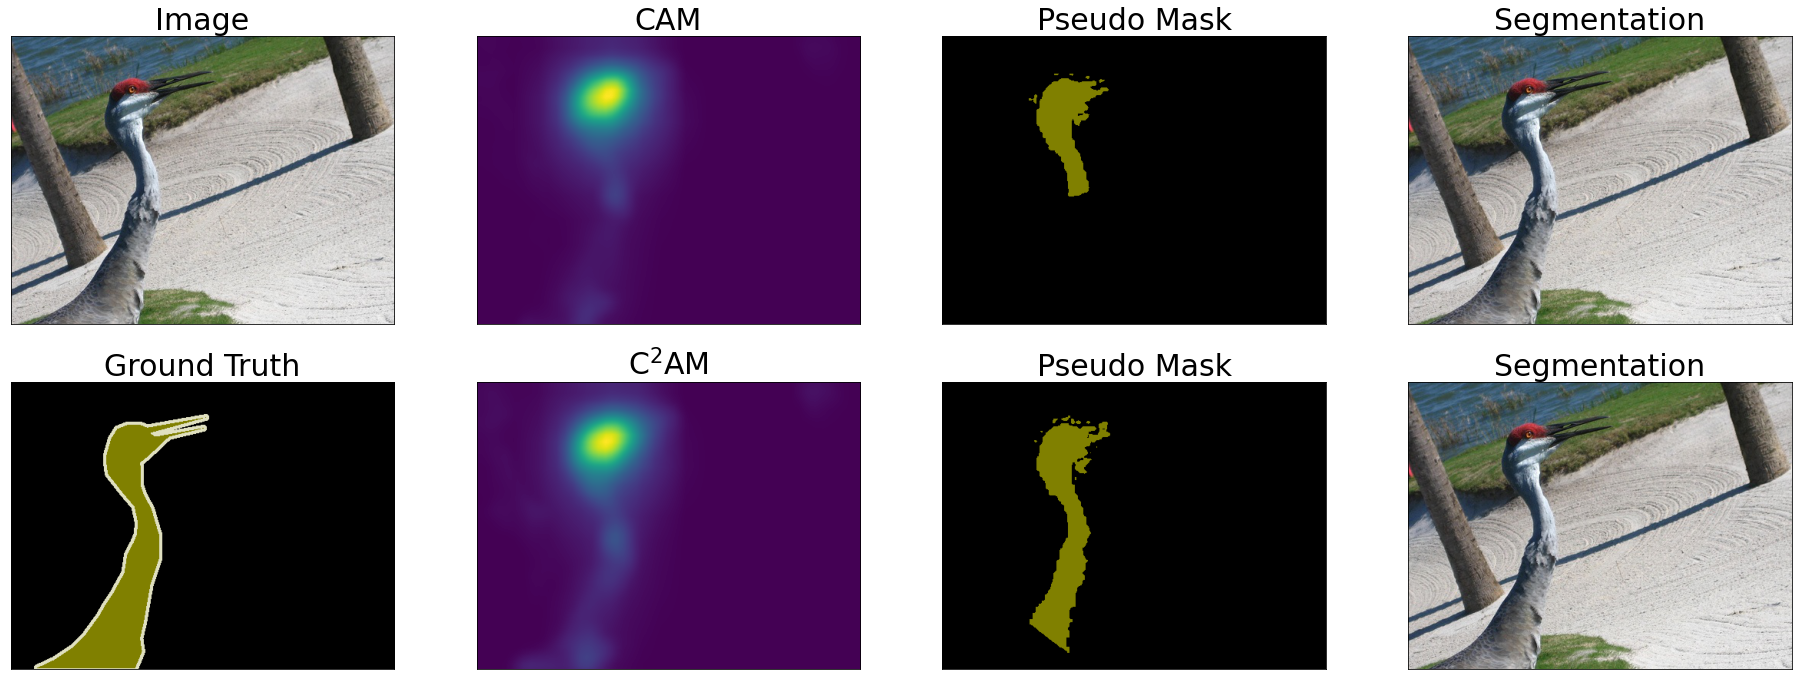

In [60]:
img_name = '2007_000068'
plot(img_name)

In [166]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.resnet50 = resnet50.resnet50(
            pretrained=True, strides=(2, 2, 2, 1))

        self.stage1 = nn.Sequential(self.resnet50.conv1, self.resnet50.bn1, self.resnet50.relu, self.resnet50.maxpool,
                                    self.resnet50.layer1)
        self.stage2 = nn.Sequential(self.resnet50.layer2)
        self.stage3 = nn.Sequential(self.resnet50.layer3)
        self.stage4 = nn.Sequential(self.resnet50.layer4)

        self.classifier = nn.Conv2d(2048, 20, 1, bias=False)

        self.backbone = nn.ModuleList(
            [self.stage1, self.stage2, self.stage3, self.stage4])
        self.newly_added = nn.ModuleList([self.classifier])

    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        feat = torchutils.gap2d(x, keepdims=True)
        print(feat.shape)
        print(feat[0][0])
        x = self.classifier(feat)
        x = x.view(-1, 20)
        return x, feat.squeeze()

    def train(self, mode=True):
        super(Net, self).train(mode)
        for p in self.resnet50.conv1.parameters():
            p.requires_grad = False
        for p in self.resnet50.bn1.parameters():
            p.requires_grad = False

    def trainable_parameters(self):
        return (list(self.backbone.parameters()), list(self.newly_added.parameters()))

In [32]:
train_dataset = voc12.dataloader.VOC12ClassificationDataset(train_list, voc12_root=voc12_root,
                                                            resize_long=(320, 640), hor_flip=False,
                                                            crop_size=512)
train_data_loader = DataLoader(train_dataset,
                                batch_size=1,
                                shuffle=False,
                                num_workers=0,
                                pin_memory=True,
                                drop_last=False)

In [154]:
data_iter = iter(train_data_loader)
pack = next(data_iter)
pack = next(data_iter)
pack = next(data_iter)
pack = next(data_iter)
pack = next(data_iter)
pack = next(data_iter)
pack = next(data_iter)
pack = next(data_iter)
pack = next(data_iter)

In [179]:
baseline_cam_weight_path = '/Users/Andy/Projects/resnet50_c2am_exp_03.pth'
model = Net()
model.eval()
model.load_state_dict(torch.load(baseline_cam_weight_path, map_location='cpu'))

imgs = pack['img']
labels = pack['label']

x, _ = model(imgs)
loss = torch.nn.BCEWithLogitsLoss()(x * 0.15, labels)
loss.backward()
print(x)

torch.Size([1, 2048, 1, 1])
tensor([[2.2186]], grad_fn=<SelectBackward0>)
tensor([[-38.2997, -28.0463, -30.4443, -31.7087,   9.9232, -42.3442, -30.6312,
         -22.4917,  -7.6034, -46.4433,   4.6016, -38.3172, -45.3079, -35.2954,
         -16.8629, -11.8846, -47.6852, -21.5753, -45.7551, -22.7189]],
       grad_fn=<ViewBackward0>)


In [163]:
print(model.classifier.weight.grad.shape)
print(model.classifier.weight.grad[4][0])
print(model.classifier.weight.grad[10][0])
print(labels)

torch.Size([20, 2048, 1, 1])
tensor([[-0.0014]])
tensor([[-0.0020]])
tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])


In [164]:
def coef_p(x, m):
    return -m * np.exp(-m * x)

def sigmoid(x):
    return 1./(1. + np.exp(-x))

In [178]:
print(1e-4 * coef_p(5.8712, 0.15) * sigmoid(0.15 * 5.8712) / 20 * 0.6292)
print(1e-4 * coef_p(2.0901, 0.15) * sigmoid(0.15 * 2.0901) / 20 * 0.6292)

print(5e-7 * model.classifier.weight[4][0])
print(5e-7 * model.classifier.weight[10][0])

-1.3828410651287835e-07
-1.9926307826624127e-07
tensor([[4.4787e-08]], grad_fn=<MulBackward0>)
tensor([[9.6366e-09]], grad_fn=<MulBackward0>)
